# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
import os, sys
import time
from datetime import datetime
from importlib import reload
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [167]:
from keras.layers import Input, Embedding, Concatenate, Reshape, Lambda, GlobalMaxPooling1D, BatchNormalization
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

In [10]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, preprocess
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling

In [6]:
from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

## Data Preparation

In [85]:
cohort = 'ami'
tst_seed = 0

In [86]:
all_df = pd.read_csv(path+'cohorts30/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)

Define the dictionaries for DX, DX1 and hosp, from value to int. Seperating DX1:

In [87]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))
code_cat = ['missing']+sorted(dx_multi.ICD9CM_CODE)*2+sorted(pr_multi.ICD9CM_CODE)+sorted(dx_ccs_cat)[1:]*2+sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)    
dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 
                                             1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))


hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

### Data Formatting

In [88]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(j) for j in range(2, n_DX+2)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [89]:
tst_key = pd.read_csv(path+'cohorts30/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [90]:
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()
n_pay1 = int(train_df0['PAY1'].max())+1
n_ed = int(train_df0['HCUP_ED'].max())+1
n_zipinc = int(train_df0['ZIPINC_QRTL'].max())+1

In [150]:
DX1_array_tst = tst_df.DX1.map(DX1_dict).values
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'
for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)
DX_mat_tst = DX_df_tst.values
PR_df_tst = tst_df[PRs]
PR_df_tst = PR_df_tst.fillna('missing')
PR_df_tst[PR_df_tst.isin(['invl', 'incn'])] = 'missing'
for pr in PRs:
    PR_df_tst[pr] = PR_df_tst[pr].map(PR_dict)
PR_mat_tst = PR_df_tst.values
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values
hosp_ohe_tst = np.zeros((len(tst_df), len(hosp_cat)))
for j in range(hosp_ohe_tst.shape[0]):
    for i in range(hosp_ohe_tst.shape[1]):
        hosp_ohe_tst[j, hosp_array_tst[i]] = 1.
pay1_mat_tst = to_categorical(tst_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)
y_true = tst_df.readm30.astype(int).values

In [92]:
n_fold = 5

In [93]:
skf = StratifiedKFold(n_splits=n_fold, random_state=24, shuffle=True)
trn_idx, val_idx = next(skf.split(train_df0, train_df0.HOSP_NRD))
trn_df = train_df0.loc[trn_idx]
val_df = train_df0.loc[val_idx]
N_trn = len(trn_df)
train_df = pd.concat([trn_df, val_df])

In [149]:
DX1_series = train_df['DX1'].map(DX1_dict)
DX1_array = DX1_series.values
DX1_array_trn = DX1_array[:N_trn]
DX1_array_val = DX1_array[N_trn:]
    
DX_df = train_df[DXs]
DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'
for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)
DX_mat = DX_df.values
DX_mat_trn = DX_mat[:N_trn, ]
DX_mat_val = DX_mat[N_trn:, ]
    
PR_df = train_df[PRs]
PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)
PR_mat = PR_df.values
PR_mat_trn = PR_mat[:N_trn, ]
PR_mat_val = PR_mat[N_trn:, ]
    
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values
hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]
hosp_ohe = np.zeros((len(train_df), len(hosp_cat)))
for j in range(hosp_ohe.shape[0]):
    for i in range(hosp_ohe.shape[1]):
        hosp_ohe[j, hosp_array[i]] = 1.
hosp_ohe_trn = hosp_ohe[:N_trn, :]
hosp_ohe_val = hosp_ohe[N_trn:, :]

demo_mat = train_df[['AGE', 'FEMALE']].values
demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std
pay1_mat = to_categorical(train_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array = train_df.LOS.values
los_array = (los_array - los_mean)/los_std
ed_mat = to_categorical(train_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat = to_categorical(train_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
other_mat = np.concatenate((demo_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), ed_mat, zipinc_mat), axis=1)
other_mat_trn = other_mat[:N_trn, ]
other_mat_val = other_mat[N_trn:, ]
    
y = train_df['readm30'].values.astype(int)
y_trn = y[:N_trn]
y_val = y[N_trn:]
Y_trn = to_categorical(y_trn)
Y_val = to_categorical(y_val)

## Model Building

In [95]:
from setsum_layer import SetSum, MaskedSum, MaskedDense

In [232]:
code_embed_dim = 200
hosp_embed_dim = 1
fc_width = 64
md_width = 128
rho_width = 32
penalty = 0.
count_cap = 20

In [97]:
embed_glove = np.load(path+'all/sepdx1/test_embed/cosine/embed_mat_{0}_{1:.3f}_{2}_{3}{4}.npy'.format(code_embed_dim, penalty, count_cap, cohort, 
                                                                                    tst_seed))
embed_initializer = Constant(embed_glove)

In [75]:
embed_initializer = 'uniform'

In [98]:
embed_glove.shape

(35952, 200)

In [36]:
n_code_cat

35952

In [112]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                     name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)

input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
DX_feature = MaskedDense(md_width, activation='relu')(DX_embed)
DX_feature = MaskedSum()(DX_feature)

input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer,
                     name='PR_embed')(input_PR)
PR_feature = MaskedDense(md_width, activation='relu')(PR_embed)
PR_feature = MaskedSum()(PR_feature)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

input_other = Input(shape=(other_mat.shape[1], ))

merged = Concatenate(axis=1)([DX1_embed, DX_feature, PR_feature, hosp_embed, input_other])

x = Dense(fc_width, activation='relu')(merged)
x = Dropout(0.3)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [256]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                     name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
DX1_embed = Dense(rho_width, activation='relu')(DX1_embed)
input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                     name='DX_embed')(input_DX)
#DX_feature = MaskedDense(md_width, activation='relu')(DX_embed)
DX_feature = Dense(md_width, activation='relu')(DX_embed)
#DX_feature = BatchNormalization()(DX_feature)
#DX_feature = Activation('relu')(DX_feature)
#DX_feature = MaskedSum()(DX_feature)
DX_feature = Lambda(lambda x:K.sum(x, axis=1))(DX_feature)
#DX_feature = Dense(rho_width, activation='relu')(DX_feature)
input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer,
                     name='PR_embed')(input_PR)
#PR_feature = MaskedDense(md_width, activation='relu')(PR_embed)
PR_feature = Dense(md_width, activation='relu')(PR_embed)
#PR_feature = BatchNormalization()(PR_feature)
#PR_feature = Activation('relu')(PR_feature)
#PR_feature = MaskedSum()(PR_feature)
PR_feature = Lambda(lambda x:K.sum(x, axis=1))(PR_feature)
#PR_feature = Dense(rho_width, activation='relu')(PR_feature)
input_hosp = Input(shape=(len(hosp_cat),))
input_other = Input(shape=(other_mat.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_feature, PR_feature, input_other])

x = Dense(fc_width, activation='relu')(merged)
x = Concatenate(axis=1)([x, input_hosp])

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [257]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = False

In [124]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = True

In [258]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [125]:
adam = Adam(lr=0.00002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [144]:
#checkpoint = ModelCheckpoint(filepath=model_path+'ami_glove_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_glove_auc1.h5', validation_y=Y_val, 
                             validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [145]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [146]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                 batch_size=512, epochs=15, callbacks=[checkpoint, auccheckpoint, reduce_lr], class_weight=class_weight, 
                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                verbose=1)

ValueError: Error when checking input: expected input_29 to have shape (874,) but got array with shape (1,)

In [259]:
#checkpoint = ModelCheckpoint(filepath=model_path+'ami_glove_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_glove_auc1.h5', validation_y=Y_val, 
                             validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_ohe_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [260]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_ohe_trn, other_mat_trn], Y_trn, 
                 batch_size=512, epochs=20, callbacks=[checkpoint, auccheckpoint, reduce_lr], class_weight=class_weight, 
                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_ohe_val, other_mat_val], Y_val], 
                verbose=1)

Train on 131070 samples, validate on 33210 samples
Epoch 1/20
131070/131070 [==============================] - 4s 34us/step - loss: 1.2789 - val_loss: 0.5048
AUC: 0.7118

Epoch 2/20
131070/131070 [==============================] - 3s 22us/step - loss: 1.2489 - val_loss: 0.6306
AUC: 0.7171

Epoch 3/20
131070/131070 [==============================] - 3s 22us/step - loss: 1.2401 - val_loss: 0.6452
AUC: 0.7194

Epoch 4/20
131070/131070 [==============================] - 3s 22us/step - loss: 1.2360 - val_loss: 0.6175
AUC: 0.7191

Epoch 5/20
131070/131070 [==============================] - 3s 22us/step - loss: 1.2325 - val_loss: 0.6090
AUC: 0.7198

Epoch 6/20
131070/131070 [==============================] - 3s 22us/step - loss: 1.2303 - val_loss: 0.5510
AUC: 0.7219

Epoch 7/20
131070/131070 [==============================] - 3s 23us/step - loss: 1.2285 - val_loss: 0.5706
AUC: 0.7215

Epoch 8/20
131070/131070 [==============================] - 3s 23us/step - loss: 1.2246 - val_loss: 0.6036
AU

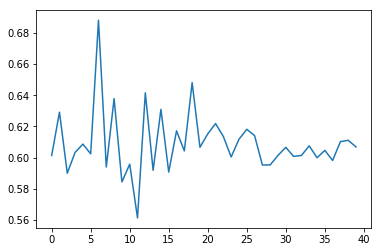

In [52]:
plt.plot(hist.history['val_loss'])

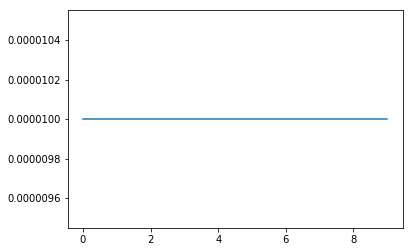

In [67]:
plt.plot(hist.history['lr'])

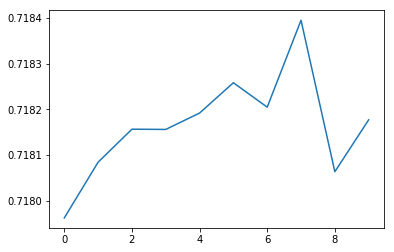

In [68]:
plt.plot(auccheckpoint.auc_history)

In [261]:
model.load_weights(model_path+'ami_glove_auc1.h5')

In [156]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

ValueError: Error when checking input: expected input_29 to have shape (874,) but got array with shape (1,)

In [262]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_ohe_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18689/18689 [==============================] - 1s 59us/step


{0: 0.7168705600896075}

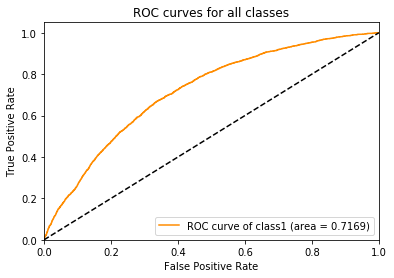

In [263]:
plot_roc(y_pred, y_true)

## Model Average

In [7]:
from sklearn.metrics import roc_curve, auc

In [8]:
y_pred_lst = []
n_fold = 10
for fold_ind in range(n_fold):
    y_pred_lst.append(np.load('output/y_pred'+str(fold_ind)+'.npy'))

In [10]:
y_true = tst_df.readm30.astype(int).values

In [11]:
auc_lst = []

for y_pred in y_pred_lst:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auc_lst.append(roc_auc)

In [12]:
np.mean(auc_lst), np.max(auc_lst), np.min(auc_lst)

(0.712201901320557, 0.7147529128986604, 0.70995568503486)

In [13]:
y_pred_mat = np.column_stack(y_pred_lst)

In [14]:
y_pred_avg = y_pred_mat.mean(axis=1)

{0: 0.7154705749444924}

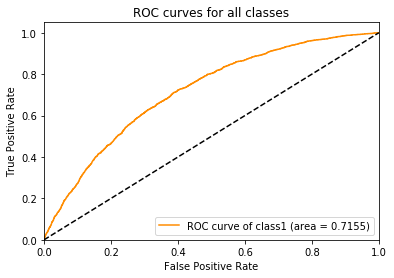

In [15]:
plot_roc(y_pred_avg, y_true)

In [16]:
np.save('output/y_pred_ami_sepdx1_10.npy', y_pred_mat)

## Separate Hospital Embeddings

In [11]:
cohort = 'ami'
tst_seed = 0

In [25]:
all_df = pd.read_csv(path+'cohorts30/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)
tst_key = pd.read_csv(path+'cohorts30/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [13]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories
DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))
code_cat = ['missing']+sorted(dx_multi.ICD9CM_CODE)*2+sorted(pr_multi.ICD9CM_CODE)+sorted(dx_ccs_cat)[1:]*2+sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)    
dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 
                                                 1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

n_DX = 29
n_PR = 15
DXs = ['DX'+str(j) for j in range(2, n_DX+2)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [26]:
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()
n_pay1 = int(train_df0['PAY1'].max())+1
n_ed = int(train_df0['HCUP_ED'].max())+1
n_zipinc = int(train_df0['ZIPINC_QRTL'].max())+1
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values
pay1_mat_tst = to_categorical(tst_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)

In [21]:
code_embed_dim = 200
embed_initializer = 'uniform'
fc_width = 512
md_width = 128
lr1 = 2e-4
lr2 = 2e-5
dropout = 0
batchsize = 256
penalty = 0.
hosp_embed_dim = 1

In [27]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                             name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                             name='DX_embed')(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
DX_embed = MaskedSum()(DX_embed)
input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer,
                             name='PR_embed')(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
PR_embed = MaskedSum()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_tst.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, input_other])
x = Dense(fc_width, activation='relu')(merged)
x = Dropout(dropout)(x)
x = Concatenate(axis=1)([x, hosp_embed])
prediction = Dense(1, activation='sigmoid', name='prediction', use_bias=False)(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [28]:
model.load_weights(model_path+'best30_hosp_ami0_0.h5')

In [30]:
hosp_embed_layer = model.layers[15]

In [32]:
hosp_embed_mat = hosp_embed_layer.get_weights()[0]

In [43]:
hosp_embed_mat.std()

0.044123374

In [41]:
hosp_embed_mat = hosp_embed_mat*(model.layers[-1].get_weights()[0][-1, 0])

In [66]:
hosp_embed_mats = []
last_weights = []
tst_seed = 1
for val_seed in range(9):
    model.load_weights(model_path+'best30_hosp_{}{}_{}.h5'.format(cohort, tst_seed, val_seed))
    hosp_embed_layer = model.layers[15]
    hosp_embed_mat = (hosp_embed_layer.get_weights()[0])*(model.layers[-1].get_weights()[0][-1, 0])
    hosp_embed_mats.append(hosp_embed_mat)
    last_weights.append((model.layers[-1].get_weights()[0][-1, 0]))

In [67]:
for hosp_embed_mat in hosp_embed_mats:
    hosp_embed_mat = (hosp_embed_mat - hosp_embed_mat.mean())/(hosp_embed_mat.std())

In [68]:
hosp_embed_mats = np.column_stack(hosp_embed_mats)

In [69]:
hosp_embed_avg1 = hosp_embed_mats.mean(axis=1)

In [65]:
hosp_embed_avg0.shape

(874,)

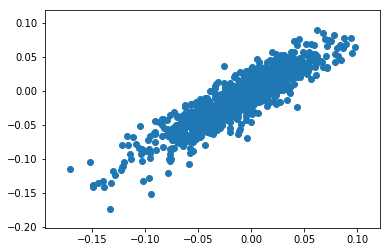

In [70]:
plt.scatter(hosp_embed_avg0, hosp_embed_avg1)